In [538]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.metrics import specificity_score

import os

#### Information on data:
- Booking data for 2 hotels 
- Both hotels are located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon
- Source: https://www.sciencedirect.com/science/article/pii/S2352340918315191

#### Model: 
- Bookings cancellation prediction: development of prediction models to classify a hotel booking׳s likelihood to be canceled. 
- Or do a cancelation ratio per day & probability of it to occur (??)

### Read clean data from csv

In [539]:
data = pd.read_csv('../data/Hotels.csv')

In [540]:
pd.set_option('display.max_columns', None)

In [541]:
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel,Arrival_Date_MonthN,ArrivalDateFull,TotalNights
0,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,Not applicable,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
1,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,Not applicable,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1,7,2015-07-01,1
2,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
3,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,Not applicable,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1,7,2015-07-01,2
4,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,Not applicable,Not applicable,0,Transient,107.0,0,0,Check-Out,2015-07-03,H1,7,2015-07-01,2


In [542]:
data = data[data.Hotel=='H1']
data.Hotel.value_counts()

H1    39665
Name: Hotel, dtype: int64

### Feature engineering

In [543]:
data_drop = data.sample(10000)

Drop irrelevant columns

In [544]:
data_drop.drop(['TotalNights', 'ArrivalDateFull', 'Arrival_Date_MonthN', 'ReservationStatusDate', 
                'TotalOfSpecialRequests', 'AssignedRoomType', 'Meal', 'ReservationStatus', 
                'Hotel', 'Country', 'RequiredCarParkingSpaces', 'ReservedRoomType', 'Agent', 'Company'], axis=1, inplace=True)

In [545]:
print(data_drop.shape)
data_drop.head()

(10000, 24)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR
33049,0,21,2017,February,7,18,2,2,2,0.0,0,Online TA,TA/TO,0,0,0,E,0,No Deposit,241,Not applicable,0,Transient,47.25
18548,0,0,2016,April,15,7,0,1,1,0.0,0,Corporate,Corporate,1,0,1,A,0,No Deposit,Not applicable,94,0,Transient,39.00
25522,0,143,2016,June,27,26,4,10,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,D,0,No Deposit,69,Not applicable,0,Transient,95.40
5606,1,203,2016,May,20,10,0,2,2,0.0,0,Groups,TA/TO,0,0,0,A,0,No Deposit,248,Not applicable,0,Transient-Party,46.00
24251,0,122,2016,May,21,17,2,5,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,D,2,No Deposit,314,Not applicable,0,Transient,83.13


#### Reduce Agent & Company to have only top agents

In [546]:
data_drop.Agent = [agent.strip() for agent in data_drop.Agent]

In [547]:
top = list(data_drop.Agent.value_counts().head(10).index)
top = [x for x in top if x != 'Not applicable']
top

['240', '250', '241', '40', '314', '242', '6', '243', '96']

In [548]:
for agent in data_drop.Agent:
    if agent == 'Not applicable':
        continue
    if agent not in top:
        data_drop.Agent = data_drop.Agent.replace(agent, 'Other')
    else:
        continue

In [549]:
data_drop.Agent.value_counts()

240               3440
Other             2217
Not applicable    2114
250                711
241                435
40                 245
314                241
242                176
6                  154
243                138
96                 129
Name: Agent, dtype: int64

#### Company

In [550]:
top_comp = list(data_drop.Company.value_counts().head(10).index)
top_comp = [x for x in top_comp if x != 'Not applicable']
top_comp

['       Not applicable',
 '        223',
 '        281',
 '        154',
 '         94',
 '        405',
 '        331',
 '         47',
 '         20',
 '        498']

In [551]:
for company in data_drop.Company:
    if company == 'Not applicable':
        continue
    if company not in top_comp:
         data_drop.Company = data_drop.Company.replace(company, 'Other')
    else:
        continue

In [552]:
data_drop.Company.value_counts()

       Not applicable    9194
Other                     420
        223               199
        281                35
        154                33
         94                29
        405                23
        331                20
         47                17
         20                15
        498                15
Name: Company, dtype: int64

In [553]:
print(data_drop.shape)
data_drop.head()

(10000, 24)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR
33049,0,21,2017,February,7,18,2,2,2,0.0,0,Online TA,TA/TO,0,0,0,E,0,No Deposit,241,Not applicable,0,Transient,47.25
18548,0,0,2016,April,15,7,0,1,1,0.0,0,Corporate,Corporate,1,0,1,A,0,No Deposit,Not applicable,94,0,Transient,39.00
25522,0,143,2016,June,27,26,4,10,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,D,0,No Deposit,Other,Not applicable,0,Transient,95.40
5606,1,203,2016,May,20,10,0,2,2,0.0,0,Groups,TA/TO,0,0,0,A,0,No Deposit,Other,Not applicable,0,Transient-Party,46.00
24251,0,122,2016,May,21,17,2,5,2,0.0,0,Offline TA/TO,TA/TO,0,0,0,D,2,No Deposit,314,Not applicable,0,Transient,83.13


### One Hot Encoding

In [554]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 33049 to 39626
Data columns (total 24 columns):
IsCanceled                     10000 non-null int64
LeadTime                       10000 non-null int64
ArrivalDateYear                10000 non-null int64
ArrivalDateMonth               10000 non-null object
ArrivalDateWeekNumber          10000 non-null int64
ArrivalDateDayOfMonth          10000 non-null int64
StaysInWeekendNights           10000 non-null int64
StaysInWeekNights              10000 non-null int64
Adults                         10000 non-null int64
Children                       10000 non-null float64
Babies                         10000 non-null int64
MarketSegment                  10000 non-null object
DistributionChannel            10000 non-null object
IsRepeatedGuest                10000 non-null int64
PreviousCancellations          10000 non-null int64
PreviousBookingsNotCanceled    10000 non-null int64
ReservedRoomType               10000 non-null obje

In [555]:
data_dummies = pd.get_dummies(data=data_drop, columns=['ArrivalDateMonth', 'MarketSegment', 'DistributionChannel',
                                                       'ReservedRoomType', 'DepositType', 'Agent', 'CustomerType',
                                                      'Company'])

In [556]:
print(data_dummies.shape)
data_dummies.head()

(10000, 75)


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,ArrivalDateMonth_April,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,ArrivalDateMonth_January,ArrivalDateMonth_July,ArrivalDateMonth_June,ArrivalDateMonth_March,ArrivalDateMonth_May,ArrivalDateMonth_November,ArrivalDateMonth_October,ArrivalDateMonth_September,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,ReservedRoomType_A,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,Agent_240,Agent_241,Agent_242,Agent_243,Agent_250,Agent_314,Agent_40,Agent_6,Agent_96,Agent_Not applicable,Agent_Other,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,Company_ 20,Company_ 47,Company_ 94,Company_ 154,Company_ 223,Company_ 281,Company_ 331,Company_ 405,Company_ 498,Company_ Not applicable,Company_Other
33049,0,21,2017,7,18,2,2,2,0.0,0,0,0,0,0,0,47.25,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
18548,0,0,2016,15,7,0,1,1,0.0,0,1,0,1,0,0,39.00,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
25522,0,143,2016,27,26,4,10,2,0.0,0,0,0,0,0,0,95.40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
5606,1,203,2016,20,10,0,2,2,0.0,0,0,0,0,0,0,46.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
24251,0,122,2016,21,17,2,5,2,0.0,0,0,0,0,2,0,83.13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


## Testing ML Models

In [557]:
df_ml=data_dummies.copy()

##### Proportion of canceled vs non canceled in full ml dataset:

In [558]:
df_ml['IsCanceled'].value_counts(normalize=True)

0    0.7248
1    0.2752
Name: IsCanceled, dtype: float64

##### Define X and y:

In [559]:
y = df_ml["IsCanceled"]
X_cols = [col for col in df_ml.columns if col != "IsCanceled"]
X = df_ml[X_cols]

In [560]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model selection loop:

In [561]:
# Code to avoid XGBoost crashing the kernel:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [562]:
models = [('Logistic Regression', LogisticRegression()), 
          ('Gausian Naive Bayes', GaussianNB()),
          ('Decision Tree', DecisionTreeClassifier()), 
          ('SVM', SVC()),
          ('Random Forest', RandomForestClassifier()),
          ('Gradient Boosting Classifier', GradientBoostingClassifier()),
          ('XG Boost', XGBClassifier())]

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'auc': 'roc_auc'}

results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=48)
    cv_results = model_selection.cross_validate(model, X=X_train, y=y_train, cv=kfold, 
                                                scoring=scoring, return_train_score=False)
    results.append([name, cv_results['test_accuracy'].mean(), 
                    cv_results['test_precision'].mean(), 
                    cv_results['test_recall'].mean(),
                   cv_results['test_f1'].mean(),
                   cv_results['test_auc'].mean()])

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_cl

In [563]:
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
df_results = pd.DataFrame(data=results, columns=headers)
df_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.759875,0.694465,0.251040,0.367899,0.749767
1,Gausian Naive Bayes,0.501125,0.345407,0.881291,0.495891,0.751211
2,Decision Tree,0.755750,0.560778,0.578487,0.568507,0.706627
3,SVM,0.721250,0.000000,0.000000,0.000000,0.723370
4,Random Forest,0.809125,0.719658,0.517091,0.601110,0.840145
5,Gradient Boosting Classifier,0.796000,0.709593,0.456392,0.554733,0.828872
6,XG Boost,0.795625,0.709875,0.453499,0.552498,0.828856


Export to csv to use in tableau

In [564]:
df_results.to_csv('../data/ModelSelectionResultsH1.csv', index=False)

### Fine tune hyper-parameters on best model:  Random Forest Classifier

Initate model:

In [649]:
rand_for = RandomForestClassifier()

Define parameter list:

In [650]:
param_grid_rf = {'max_features': [5, 7, 10, None],
                 'max_depth': [5, 10, 15],
              'n_estimators': [1, 5, 10, 20, 50, 100, 200],
             'class_weight': [{0: 0.72, 1: 0.28}, 'balanced'],
                'max_samples': [0.3]}

# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree
# class_weight = Weights associated with classes in the form {class_label: weight}

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [651]:
grid_rf = GridSearchCV(rand_for, param_grid_rf, cv=5)

Fit this grid to the train dataset:

In [652]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Print score for best performing hyper-parameters & best hyper-parameters:

In [653]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.8057500000000001
{'class_weight': 'balanced', 'max_depth': 15, 'max_features': None, 'max_samples': 0.3, 'n_estimators': 100}


Save this best scoring estimator as a model:

In [654]:
model_rf=grid_rf.best_estimator_

In [655]:
cxl_proba_rf = model_rf.predict_proba(X_test)
cxl_proba_rf

array([[0.99456201, 0.00543799],
       [0.75088323, 0.24911677],
       [0.        , 1.        ],
       ...,
       [0.94425627, 0.05574373],
       [0.54812518, 0.45187482],
       [0.70658983, 0.29341017]])

In [656]:
# show the inputs and predicted probabilities
pred_rf= model_rf.predict(X_test)

for i in range(len(y_test)):
    print("Probability=%s, Predicted=%s" % (cxl_proba_rf[i], pred_rf[i]))

Probability=[0.99456201 0.00543799], Predicted=0
Probability=[0.75088323 0.24911677], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.34842198 0.65157802], Predicted=1
Probability=[0.92550002 0.07449998], Predicted=0
Probability=[0.58509743 0.41490257], Predicted=0
Probability=[0.32206535 0.67793465], Predicted=1
Probability=[0.40026892 0.59973108], Predicted=1
Probability=[0.85426191 0.14573809], Predicted=0
Probability=[0.82585608 0.17414392], Predicted=0
Probability=[0.44087309 0.55912691], Predicted=1
Probability=[0.92909854 0.07090146], Predicted=0
Probability=[0.86296375 0.13703625], Predicted=0
Probability=[0.85396482 0.14603518], Predicted=0
Probability=[0.65092021 0.34907979], Predicted=0
Probability=[0.79337316 0.20662684], Predicted=0
Probability=[0.97984183 0.02015817], Predicted=0
Probability=[0.96065539 0.03934461], Predicted=0
Probability=[0.75057514 0.24942486], Predicted=0
Probability=[0.64888741 0.35111259], Predicted=0
Probability=[0.6352582 0.3647418], P

Probability=[0.6215044 0.3784956], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.69696523 0.30303477], Predicted=0
Probability=[0.98796934 0.01203066], Predicted=0
Probability=[0.93959316 0.06040684], Predicted=0
Probability=[0. 1.], Predicted=1
Probability=[0.77339624 0.22660376], Predicted=0
Probability=[0.83 0.17], Predicted=0
Probability=[0.87905718 0.12094282], Predicted=0
Probability=[0.8 0.2], Predicted=0
Probability=[0.61876526 0.38123474], Predicted=0
Probability=[0.94799475 0.05200525], Predicted=0
Probability=[0.81373671 0.18626329], Predicted=0
Probability=[0.7628046 0.2371954], Predicted=0
Probability=[0.8170706 0.1829294], Predicted=0
Probability=[1. 0.], Predicted=0
Probability=[0.66010365 0.33989635], Predicted=0
Probability=[0.6559437 0.3440563], Predicted=0
Probability=[0.4407087 0.5592913], Predicted=1
Probability=[0.96461911 0.03538089], Predicted=0
Probability=[0.82237117 0.17762883], Predicted=0
Probability=[0.96698881 0.03301119], Predicted=0
Probab

Probability=[0.99811004 0.00188996], Predicted=0
Probability=[0.5880745 0.4119255], Predicted=0
Probability=[0.84985964 0.15014036], Predicted=0
Probability=[0.64779635 0.35220365], Predicted=0
Probability=[0.75087719 0.24912281], Predicted=0
Probability=[0.6165657 0.3834343], Predicted=0
Probability=[0.8070416 0.1929584], Predicted=0
Probability=[0.50819827 0.49180173], Predicted=0
Probability=[0.99114125 0.00885875], Predicted=0
Probability=[0.91903588 0.08096412], Predicted=0
Probability=[0.87887217 0.12112783], Predicted=0
Probability=[0.84217089 0.15782911], Predicted=0
Probability=[0.64798235 0.35201765], Predicted=0
Probability=[0.98480449 0.01519551], Predicted=0
Probability=[0.90055616 0.09944384], Predicted=0
Probability=[0.79728625 0.20271375], Predicted=0
Probability=[0.45982144 0.54017856], Predicted=1
Probability=[0.9133067 0.0866933], Predicted=0
Probability=[0.67065082 0.32934918], Predicted=0
Probability=[0.94733545 0.05266455], Predicted=0
Probability=[0.72009387 0.27

Probability=[0.46176252 0.53823748], Predicted=1
Probability=[0.31415184 0.68584816], Predicted=1
Probability=[0.98618195 0.01381805], Predicted=0
Probability=[0.84379156 0.15620844], Predicted=0
Probability=[0.95976708 0.04023292], Predicted=0
Probability=[0.88577254 0.11422746], Predicted=0
Probability=[0.9284049 0.0715951], Predicted=0
Probability=[0.20838748 0.79161252], Predicted=1
Probability=[0.88356929 0.11643071], Predicted=0
Probability=[0.65603095 0.34396905], Predicted=0
Probability=[0.92150157 0.07849843], Predicted=0
Probability=[0.25549635 0.74450365], Predicted=1
Probability=[0.40271378 0.59728622], Predicted=1
Probability=[0. 1.], Predicted=1
Probability=[0.85087773 0.14912227], Predicted=0
Probability=[0.98714636 0.01285364], Predicted=0
Probability=[0.91749438 0.08250562], Predicted=0
Probability=[0.75625272 0.24374728], Predicted=0
Probability=[0.73173502 0.26826498], Predicted=0
Probability=[0.78512087 0.21487913], Predicted=0
Probability=[0.62814178 0.37185822], P

Probability=[0.91101468 0.08898532], Predicted=0
Probability=[0.85917622 0.14082378], Predicted=0
Probability=[0.34970161 0.65029839], Predicted=1
Probability=[0.2741225 0.7258775], Predicted=1
Probability=[0.95672631 0.04327369], Predicted=0
Probability=[0.82808415 0.17191585], Predicted=0
Probability=[0.14419209 0.85580791], Predicted=1
Probability=[0.8841362 0.1158638], Predicted=0
Probability=[0.97890663 0.02109337], Predicted=0
Probability=[0.65732384 0.34267616], Predicted=0
Probability=[0.84565328 0.15434672], Predicted=0
Probability=[0.9191813 0.0808187], Predicted=0
Probability=[0.67263959 0.32736041], Predicted=0
Probability=[0.36655571 0.63344429], Predicted=1
Probability=[0.61533843 0.38466157], Predicted=0
Probability=[0.70971104 0.29028896], Predicted=0
Probability=[0.63953117 0.36046883], Predicted=0
Probability=[0.88019422 0.11980578], Predicted=0
Probability=[0.80744442 0.19255558], Predicted=0
Probability=[0.04772213 0.95227787], Predicted=1
Probability=[0.72594393 0.

Test this model to test dataset (final evaluation):

In [657]:
model_rf.score(X_test, y_test)

0.8035

In [658]:
pred_rf = model_rf.predict(X_test)
metrics.precision_score(y_test, pred_rf)

0.6375266524520256

Feature importances:

In [659]:
feature_importances_rf = pd.DataFrame(model_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf = feature_importances_rf.head(15)
feature_importances_rf

,importance
LeadTime,0.232658
ADR,0.117810
ArrivalDateDayOfMonth,0.075655
ArrivalDateWeekNumber,0.062186
Agent_240,0.054535
DepositType_Non Refund,0.050763
StaysInWeekNights,0.042220
MarketSegment_Offline TA/TO,0.037448
PreviousCancellations,0.032934
BookingChanges,0.028393


([<matplotlib.axis.XTick at 0x1a284fbf28>,
 <a list of 15 Text xticklabel objects>)

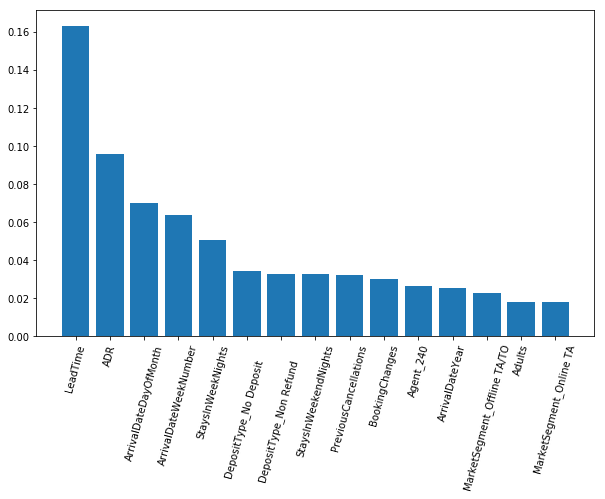

In [579]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances_rf.index, feature_importances_rf['importance'])
plt.xticks(feature_importances_rf.index, rotation=75)

Use confusion matrix to visualise results:

In [580]:
pred_rf = model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, pred_rf)
cm_rf

array([[1288,  190],
       [ 192,  330]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

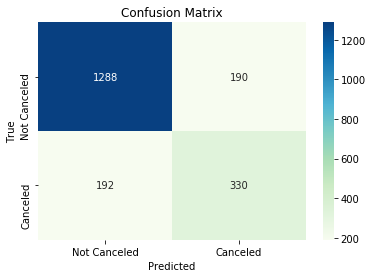

In [581]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
#cmap = plt.get_cmap('BuGn') ('summer') ('Dark2') ('Set2') ('Set3')

sns.heatmap(cm_rf, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

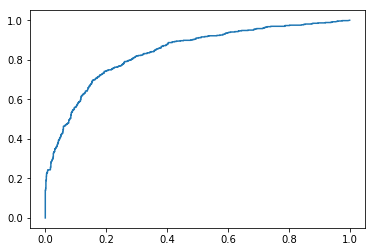

In [582]:
y_pred_proba_rf = model_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr)

### Fine tune hyper-parameters on best model:  XG Boost

Initate model:

In [583]:
xgb = XGBClassifier()

Define parameter list:

In [584]:
param_grid_xgb = {'max_depth': [5, 10, 15, 20, 50],
              'n_estimators': [1, 5, 10, 20, 50, 100, 200],
              'eta': [0.2, 0.3]}

# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [585]:
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)

Fit this grid to the train dataset:

In [586]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.2, 0.3], 'max_depth': [5, 10, 15, 20, 50],
                         'n_estimators': [1, 5, 10, 20, 50, 100, 200]},
             pre_dispatch='

Print score for best performing hyper-parameters & best hyper-parameters:

In [587]:
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

0.8078749999999999
{'eta': 0.2, 'max_depth': 10, 'n_estimators': 100}


Save this best scoring estimator as a model:

In [588]:
model_xgb=grid_xgb.best_estimator_

Test this model to test dataset (final evaluation):

In [589]:
model_xgb.score(X_test, y_test)

0.8115

In [590]:
pred_xgb = model_xgb.predict(X_test)
metrics.precision_score(y_test, pred_xgb)

0.6923076923076923

Feature importances:

In [591]:
feature_importances_xgb = pd.DataFrame(model_xgb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_xgb = feature_importances_xgb.head(15)
feature_importances_xgb

,importance
DepositType_Non Refund,0.306221
Agent_240,0.097082
PreviousCancellations,0.043007
MarketSegment_Offline TA/TO,0.038492
CustomerType_Transient,0.029124
Agent_242,0.021807
BookingChanges,0.017184
LeadTime,0.016089
PreviousBookingsNotCanceled,0.015778
MarketSegment_Corporate,0.014424


([<matplotlib.axis.XTick at 0x1a3d130588>,
 <a list of 15 Text xticklabel objects>)

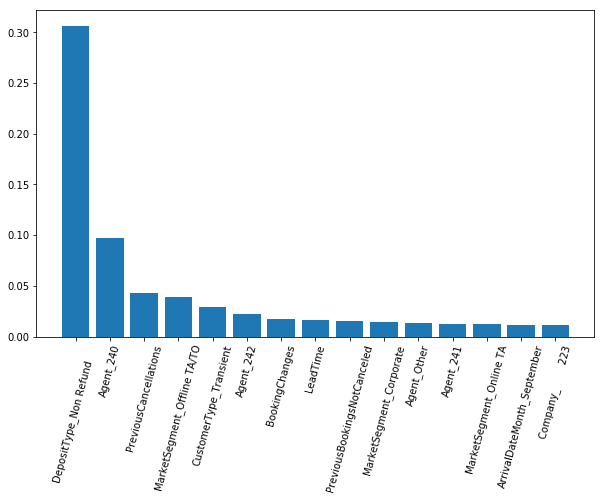

In [592]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances_xgb.index, feature_importances_xgb['importance'])
plt.xticks(feature_importances_xgb.index, rotation=75)

Use confusion matrix to visualise results:

In [593]:
pred_xgb = model_xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test, pred_xgb)
cm_xgb

array([[1362,  116],
       [ 261,  261]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

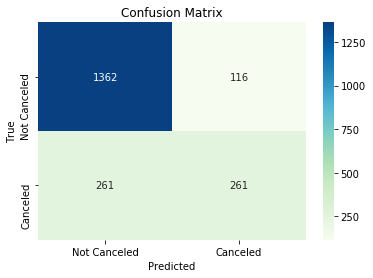

In [594]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

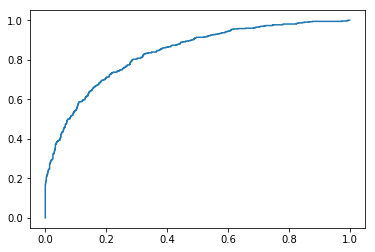

In [595]:
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_xgb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr,tpr)

### Fine tune hyper-parameters on best model:  Gradient Boosting Classifier

Initate model:

In [596]:
gbclass = GradientBoostingClassifier()

Define parameter list:

In [597]:
param_grid_gb = {'max_depth': [5, 10, 15, 20, 50],
              'max_features' : ['auto', None],
              'n_estimators': [1, 5, 10, 20, 50, 100, 200]}
               
# n_estimators = number of trees in random forest
# max_depth = maximum number of levels in tree

Pass the initated model, hyper-parameter dictionary and cross validation to the GridSearchCV:

In [598]:
grid_gb = GridSearchCV(gbclass, param_grid_gb, cv=5)

Fit this grid to the train dataset:

In [599]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

Print score for best performing hyper-parameters & best hyper-parameters:

In [600]:
print(grid_gb.best_score_)
print(grid_gb.best_params_)

0.8076249999999998
{'max_depth': 10, 'max_features': None, 'n_estimators': 50}


Save this best scoring estimator as a model:

In [601]:
model_gb=grid_gb.best_estimator_

Test this model to test dataset (final evaluation):

In [602]:
model_gb.score(X_test, y_test)

0.808

In [603]:
pred_gb = model_gb.predict(X_test)
metrics.precision_score(y_test, pred_gb)

0.6864864864864865

Feature importances:

In [604]:
feature_importances_gb = pd.DataFrame(model_gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_gb = feature_importances_gb.head(15)
feature_importances_gb

,importance
LeadTime,0.198776
DepositType_Non Refund,0.135144
ADR,0.104908
Agent_240,0.083336
ArrivalDateDayOfMonth,0.074278
ArrivalDateWeekNumber,0.049489
PreviousCancellations,0.042302
StaysInWeekNights,0.037357
BookingChanges,0.025839
CustomerType_Transient,0.022533


([<matplotlib.axis.XTick at 0x1a40aa56a0>,
 <a list of 15 Text xticklabel objects>)

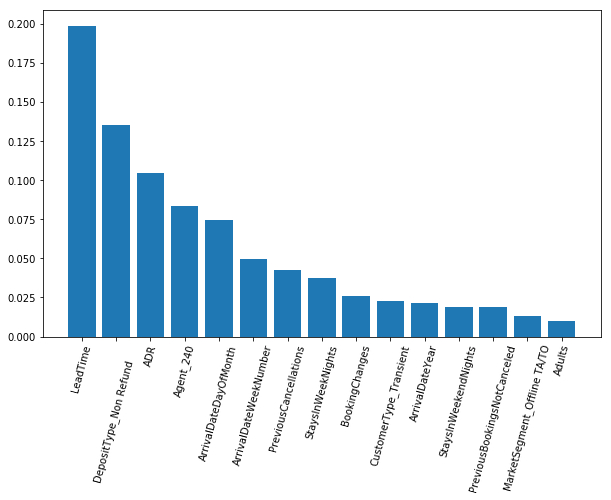

In [605]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances_gb.index, feature_importances_gb['importance'])
plt.xticks(feature_importances_gb.index, rotation=75)

Use confusion matrix to visualise results:

In [606]:
pred_gb = model_gb.predict(X_test)
cm_gb = confusion_matrix(y_test, pred_gb)
cm_gb

array([[1362,  116],
       [ 268,  254]])

Plot confusion matrix:

[Text(0, 0.5, 'Not Canceled'), Text(0, 1.5, 'Canceled')]

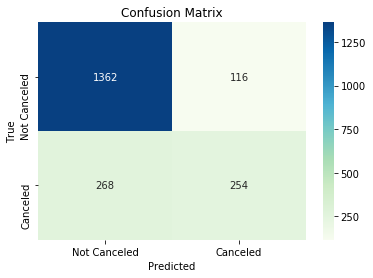

In [607]:
ax= plt.subplot()
cmap = plt.get_cmap('GnBu')
sns.heatmap(cm_gb, annot=True, ax = ax, fmt='d', cmap=cmap)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Canceled', 'Canceled'])
ax.yaxis.set_ticklabels(['Not Canceled', 'Canceled'])

Draw area under curve:

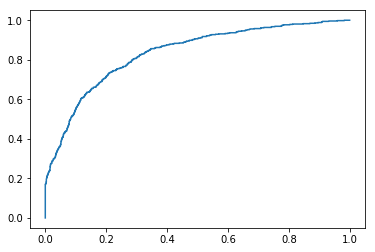

In [608]:
y_pred_proba_gb = model_gb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_gb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_gb)
plt.plot(fpr,tpr)

### Result Analysis

#### Create result df with X_test and actual vs predicted values of y

In [609]:
pred_gb = model_gb.predict(X_test)

In [610]:
df_pred_gb  = pd.DataFrame(pred_gb)

In [611]:
df_result = X_test.reset_index()
df_result["Actual"] = y_test.reset_index()["IsCanceled"]
df_result["Prediction"] = df_pred_gb.reset_index()[0]

In [612]:
df_result.head()

,index,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,ArrivalDateMonth_April,ArrivalDateMonth_August,ArrivalDateMonth_December,ArrivalDateMonth_February,ArrivalDateMonth_January,ArrivalDateMonth_July,ArrivalDateMonth_June,ArrivalDateMonth_March,ArrivalDateMonth_May,ArrivalDateMonth_November,ArrivalDateMonth_October,ArrivalDateMonth_September,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,ReservedRoomType_A,ReservedRoomType_B,ReservedRoomType_C,ReservedRoomType_D,ReservedRoomType_E,ReservedRoomType_F,ReservedRoomType_G,ReservedRoomType_H,ReservedRoomType_L,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,Agent_240,Agent_241,Agent_242,Agent_243,Agent_250,Agent_314,Agent_40,Agent_6,Agent_96,Agent_Not applicable,Agent_Other,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,Company_ 20,Company_ 47,Company_ 94,Company_ 154,Company_ 223,Company_ 281,Company_ 331,Company_ 405,Company_ 498,Company_ Not applicable,Company_Other,Actual,Prediction
0,16807,1,2016,11,8,0,1,1,0.0,0,1,0,5,0,0,43.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,33154,316,2017,8,21,0,4,2,0.0,0,0,0,0,0,0,30.6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9983,238,2017,6,10,0,2,2,0.0,0,0,0,0,0,0,54.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,4989,183,2016,16,16,1,1,2,0.0,0,0,0,0,0,0,85.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,32887,1,2017,11,18,0,1,1,0.0,0,1,0,1,2,0,35.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [613]:
df_result.Actual.value_counts()

0    1478
1     522
Name: Actual, dtype: int64

In [614]:
df_result.Prediction.value_counts()

0    1630
1     370
Name: Prediction, dtype: int64

#### Create 2 data frames with original Train (X+y) & Test (X+y) datasets (to compare feature distribution per class with predicted results)

In [615]:
df1 = pd.concat([X_test,y_test],axis=1)

In [616]:
df2 = pd.concat([X_train,y_train],axis=1)

In [646]:
df1[(df1.Agent_240 == 1)&(df1.IsCanceled==1)].shape[0]/df1[df1.Agent_240 == 1].shape[0]

0.3648255813953488

In [647]:
df2[(df2.Agent_240 == 1)&(df2.IsCanceled==1)].shape[0]/df2[df2.Agent_240 == 1].shape[0]

0.3946220930232558

In [648]:
df_result[(df_result.Agent_240 == 1)&(df_result.Prediction==1)].shape[0]/df_result[df_result.Agent_240 == 1].shape[0]

0.3488372093023256